## Cross Validation

### The validation set approach
Por lo general, no siempre se dispone de un Test set (conjunto de prueba), por lo que una estrategia simple para crearlo es dividir los datos disponibles en training y validation (conjunto de validación). Para las respuestas cuantitativas usualmente se usa el MSE (o el RMSE), para categóricas se puede usar la tasa de error, área bajo la curva, F1-score, accuracy, kappa, matriz de confusión, etc.

### Leave One Out Cross Validation (LOOCV)
LOOCV solo tiene una observación en el conjunto de validación y usa todas las demás $n-1$ observaciones para construir un modelo. Se construyen múltiples modelos omitiendo cada observación una vez y se promedia el error en estas $n$ pruebas. LOOCV es mejor que el método anterior. El modelo se basa en casi todos los datos y no hay aleatoriedad en las divisiones ya que cada observación se omite una vez. Es computacionalmente costoso especialmente con un $n$ grande y con un modelo complejo.

### k-fold cross validation
Es similar a LOOCV pero esta vez se deja un número mayor a 1 fuera (para usarlo como conjunto de validación). Aquí, $k$ es el número de particiones de la muestra, de modo que si se tiene 1000 observaciones y $k = 10$, cada iteración (fold) será 100. Estas 100 observaciones actuarían como un conjunto de test. Posteriormente, se obtiene un MSE (o tasa de error, accuracy, etc.) por cada pliegue de estas 100 observaciones y se toma el promedio. LOOCV es un caso especial de k-fold cross validation cuando $k$ es igual al número de observaciones.

### Bias-variance tradeoff entre LOOCV y k-fold CV
Dado que LOOCV usa casi todos los datos para entrenar, la tasa de error del cojunto de Test generalmente será menor que en k-fold cross validation y menos sesgada. LOOCV tiene mayor varianza ya que todos los $n$ modelos estarán altamente correlacionados entre sí. Dado que los modelos no serán muy diferentes, la tasa de error de Test (que es lo que intenta medir la validación cruzada) variará más que usando k-fold CV, el cúal tiene menos modelos que están menos correlacionados entre sí. Un valor de $k$ entre 5 y 10 es una buena regla empírica que equilibra la compensación entre el sesgo y la varianza.

In [1]:
# Cargando los modulos basicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, recall_score 
from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline, Pipeline


# Para ser reproducible
np.random.seed(42)

In [2]:
# Funcion para calcular y visualizar la matriz de confusion 
def plotCM(ytrue, ypred, clases=None, normalize = False, ax = None):
    """ Funcion para calcular y visualizar la matriz de confusion"""
    
    if clases == None:
        clases = list(set(ytrue))
        clases.sort() # etiquetas unicas ordenadas alfabeticamente
    
    CM = confusion_matrix(ytrue,ypred, labels=clases)
    
    #Normaliza la matriz de confusion dividiendo cada fila por el total de verdaderos
    if normalize:
        CM = 100*CM / CM.sum(axis=1).reshape(-1,1) #Aprovechando el Broadcasting!
 
    df = pd.DataFrame(CM, index=clases, columns=clases)
    df.index.name = 'True'; df.columns.name = 'Predicted'
    
    sns.heatmap( df, # Visualizando la matriz de confusion
             annot=True, fmt='2.1f', cmap='ocean_r',cbar=False,square=True, annot_kws={'fontsize':16}, ax=ax )
    

# Ejemplos de validación cruzada con el iris dataset

In [3]:
# Cargamos el iris dataset usando seaborn
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

### The validation set approach
El enfoque mediante un sólo conjunto de validación se implementa en scikit-learn mediante la función `sklearn.model_selection.train_test_split(*arrays, **options)`. Las entradas `*arrays` pueden ser cualquier número de secuencias indexables (listas, arrays de numpy, dataframes de pandas, etc.) con la misma longitud. La descripción completa de los parámetros se encuentra en la [documentación de la función](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 

Si esta función se utiliza con los parámetros por defecto, realiza la partición de forma aleatoria, sin tener en cuenta las proporciones de las clases. Esto puede ser contraproducente en un dataset con diferentes número de elementos por clase (es decir desbalanceado). Para tener en cuenta las proporciones de las clases se debe hacer la partición de los datos de forma *estratificada* (stratified), y se puede hacer de forma muy sencilla  utilizando `train_test_split` con el parámetro `stratify=y`, donde `y` es el vector de etiquetas de las clases.

Un alternativa para particionar de forma estratificada es usar la clase `sklearn.model_selection.StratifiedShuffelSplit()`, la cúal instancia un objeto de validación cruzada (cross validator) que puede generar índices para diferentes números de particiones (una partición es el enfoque de validación, más de una partición es k-fold CV). 

In [5]:
# from sklearn.model_selection import train_test_split

X = iris.drop(columns='species') # Toma solo los predictores
y = iris['species'] # Vector de etiquetas

X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.25, random_state=123)


In [6]:
print(X_train.shape)
print(X_test.shape)

(112, 4)
(38, 4)


Ahora se puede usar un clasificador (o varios) y evaluar la predicción sobre el conjunto de prueba. Por ejemplo, podemos usar un KNN:

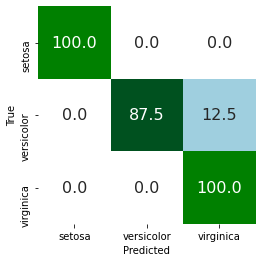

In [7]:
#Explorar y visualizar los datos para obtener información.
model = KNeighborsClassifier(n_neighbors=5).fit( X_train, y_train )
y_pred = model.predict(X_test)

plotCM(y_test,y_pred, normalize=True)

### Leave One Out Cross Validation (LOOCV)
LOOCV se implementa mediante la clase `sklearn.model_selection.LeaveOneOut`, que genera un objeto de validación cruzada (cross validator). Este "validador" suministra índices tanto para el conjunto de entrenamiento como el de prueba (training and test).  Esta técnica es computacionalmente intensiva, por lo tanto no es aconsejable usarla en datasets de tamaño grande.

Continuando con el ejemplo del Iris:

In [8]:
# from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut() # Se instancia al cross validator

loo.get_n_splits(X) # Devuelve el numero de particiones en el validador

150

Ahora se debe utilizar un bucle con el método `split()` para generar los índices:

In [9]:
for train_index, test_index in loo.split(X):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index] # son dataframes por eso se usa "loc"
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    print(X_train.shape, X_test.shape)

(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4) (1, 4)
(149, 4)

¿Algo falta? No se ha realizado ninguna clasificación. Basta con introducir los clasificadores:

In [10]:
acc = [] # Define una lista para almacenar las exactitudes

for train_index, test_index in loo.split(X):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index] # son dataframes por eso se usa "loc"
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # Implementacion del clasificador (no es la unica forma, ver sklearn.base.clone)
    model = KNeighborsClassifier(n_neighbors=5).fit( X_train, y_train )
    y_pred = model.predict(X_test)
    acc.append( accuracy_score(y_test,y_pred) )
    
mean_accuracy = np.mean(acc) # Calcula la exactitud promedio

print("Mean accuracy = ", mean_accuracy)
    

Mean accuracy =  0.9666666666666667


In [11]:
acc

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

El ejemplo anterior es un bucle más importante de lo que parece ya que se usa de forma muy similar para diferentes objetos de validación cruzada (cross validator) como `LeaveOneOut`, `StratifiedShuffelSplit`, entre otros.

### k-fold cross validation

Al igual que el enfoque con sólo un conjunto de validación, k-fold cross validation tiene dos variantes:
- La versión "normal" en la cual particiona el conjunto de datos en k subconjuntos de forma aleatoria. Se puede implementar a través de la clase `sklearn.model_selection.KFold` (cross validator).
- La versión "estratificada" en la cual las particiones contienen proporciones similares de los elementos de cada clase, se puede implementar ya sea mediante la clase `sklearn.model_selection.StratifiedKFold`. De forma más simple se puede usar la función `sklearn.model_selection.cross_val_score`, la cúal es mucho más general (sirve para LOOCV, k-fold CV no estratificado, etc.), sirve para evaluar específicamente una métrica de desempeño a través de la validación cruzada. Una alternativa a la función anterior es `sklearn.model_selection.cross_val_predict`, la cúal es muy similar a *cross_val_score* pero en vez de evaluar una métrica genera las predicciones de todas las observaciones.

La versión estratificada es más usada y es similar a la no estratificada cuando el conjunto de datos es balanceado. Por lo tanto, se verá la *Stratified k-fold cross validation*. En la documentación de scikit-learn se puede encontrar más información sobre todas las implementaciones de validación cruzada (hay más de las que trata este notebook) del módulo `sklearn.model_selection`.

#### `cross_val_score`
Esta función permite implementar de forma muy simple la validación cruzada (varios tipos de validación cruzada). [Es recomendable leer la documentación oficial de scikit-learn de esta función](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). 

Para el caso del Iris dataset, la *Stratified k-fold cross validation* se puede implementar así:

In [12]:
 from sklearn.model_selection import cross_val_score 

# Se define el modelo (sin ajustar)
model = KNeighborsClassifier(n_neighbors=5) #KNN

accuracies = cross_val_score(model, X, y, cv=5, scoring="accuracy")

In [13]:
accuracies

array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])

In [14]:
accuracies.mean()

0.9733333333333334

!Muy sencillo¡
Una breve explicación de cada entrada es necesaria (recomiendo de nuevo mirar la documentación de sklearn):
- model: es el modelo predefinido y sin ajustar
- X: los predictores
- y: vector de etiquetas
- cv: es un parámetro muy importante. Cuando es un entero, especifica el número de iteraciones o folds en una (stratified) k-fold CV. También, puede ser un objeto del tipo *cross validator*.
- scoring: normalmente es un string que especifica la métrica de evaluación, en este [link](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) se especifican todas las  posibles métricas.

¿Y si, no queremos evaluar una métrica, sino por ejemplo, una matriz de confusión?

#### `cross_val_predict`
Esta función es similar a *cross_val_score*, pero en vez de dar una métrica de evaluación (promedio o global) de las clasificaciones realizadas durante la validación cruzada, produce las predicciones hechas sobre cada conjunto de validación en cada fold (o iteración). Esto significa que se obtiene una predicción *limpia* para cada observación del conjunto de datos (*limpio* significa que la predicción es realizada por un modelo que nunca ha visto los datos durante el entrenamiento).

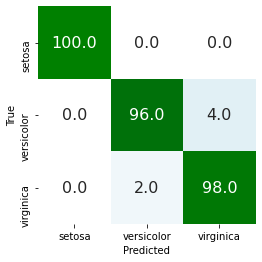

In [15]:
# from sklearn.model_selection import cross_val_predict

y_total_predict = cross_val_predict(model, X, y, cv=3, method='predict', n_jobs=-1)

# Matriz de confusion global para todas las predicciones hechas
# durante la validacion cruzada
plotCM(y,y_total_predict, normalize=True)

#### `StratifiedKFold`
Esta clase instancia un objeto del tipo *cross-validator*. Genera índices de training/test para dividir el conjunto de datos en training y test (en realidad validación).  Cada partición es hecha preservando las proporciones de las muestras para cada clase (a diferencia de `sklearn.model_selection.KFold`). La forma de usarlo es muy similar a la presentada anteriormente con `sklearn.model_selection.LeaveOneOut`.

Veamos un ejemplo con el Iris dataset, que al ser balanceado equivale a usar sólo `Kfold`:

In [16]:
# from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123) # instancia al objeto cross validator con 5 folds

acc = [] # Define una lista para almacenar las exactitudes

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index] # son dataframes por eso se usa "loc"
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # Implementacion del clasificador (no es la unica forma, ver sklearn.base.clone)
    model = KNeighborsClassifier(n_neighbors=5).fit( X_train, y_train )
    lista_model = lista_model.append(model)
    y_pred = model.predict(X_test)
    acc.append( accuracy_score(y_test,y_pred) )
    
print("Accuracy = ", acc)


NameError: name 'lista_model' is not defined

`StratifiedKFold` no es tan simple de usar como `cross_val_score`, pero tiene una mayor flexibilidad a la hora de hacer nuestras propias implementaciones. [En la documentación se encuentra la información completa de esta clase](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold).

Un ejemplo, sería obtener una matriz de confusión por cada iteración:

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123) # instancia al objeto cross validator con 5 folds

# Crea los ejes y las figuras para graficar en un subplot
fig, ax = plt.subplots(2,3, figsize = (15,10))
j = 0 # contador para acceder a los ejes
for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index] # son dataframes por eso se usa "loc"
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # Implementacion del clasificador
    model = KNeighborsClassifier(n_neighbors=5).fit( X_train, y_train )
    y_pred = model.predict(X_test)
    
    # Matriz de confusion especificando los ejes (aplanados)
    plotCM(y_test,y_pred,normalize=True, ax = ax.flatten()[j])
    j += 1
    
ax[1,2].axis('off') # No muestra el eje en la ultima posicion
plt.show() 

## Validación cruzada con preprocesamiento
#### Una primera vista al `Pipeline`
  
 Una primera forma de hacer el preprocesamiento dentro de una validación cruzada (si se hace afuera crea un sesgo grande que puede ocasionar un sobre-entrenamiento) es utilizando la función `StratifiedKFold` y un bucle similar a los anteriores:

In [ ]:
# from sklearn import preprocessing

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123) # instancia al objeto cross validator con 5 folds

acc = [] # Define una lista para almacenar las exactitudes

for train_index, test_index in skf.split(X,y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index] # son dataframes por eso se usa "loc"
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # Preprocesamiento
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) # ajusta y transforma
                                                   # equivale a usar .fit() y luego .transform()
        
    # Implementacion del clasificador 
    model = KNeighborsClassifier(n_neighbors=5).fit( X_train_scaled, y_train )
    y_pred = model.predict(scaler.transform(X_test))
    acc.append( accuracy_score(y_test,y_pred) )
    
print("Accuracy = ", acc)

Ahora usaremos un `Pipeline` muy sencillo, pero es un ejemplo de la forma tan estructurada y organizada que tiene scikit-learn y que hace que sea tan usado a nivel empresarial y de investigación.

Un `Pipeline` es una secuencia de diferentes pasos del Machine learning o aprendizaje estadístico. Por ejemplo, una codificación, seguida de un escalamiento, luego una selección de predictores y por último una clasificación.

A continuación se implementa el bucle anterior con un `Pipeline` de dos formas diferentes:

In [ ]:
# from sklearn.pipeline import make_pipeline

pipe_KNN = make_pipeline( preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5) )
cross_val_score(pipe_KNN, X, y, cv=5, scoring="accuracy")

In [ ]:
# from sklearn.pipeline import Pipeline

Pipe_KNN = Pipeline( steps=[('estandarizacion', preprocessing.StandardScaler()),
                          ('classificador_KNN', KNeighborsClassifier(n_neighbors=5))] )
cross_val_score(Pipe_KNN, X, y, cv=5, scoring="accuracy")                    

In [ ]:
pipe_KNN.fit(X_train,y_train)

In [ ]:
pipe_KNN.predict(X_test)